In [20]:
!pip install transformers
!pip install wandb

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
from transformers import AutoTokenizer, BertModel
import torch
import torch.nn as nn

import torch.optim as optim

import re
from torch.utils.data import Dataset, DataLoader, Subset

import pandas as pd
import numpy as np

import wandb

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 5
BATCH_SIZE = 16
SAVED_MODEL_PATH = "custom_bert_model.torch"
SAVED_TARGET_CAT_PATH = "bbc-news-categories.torch"
DS_PATH = "bbc-news-data.csv"

In [24]:
from typing import DefaultDict
class CustomBertDataset(Dataset):
    def __init__(self, file_path,model_path="google-bert/bert-base-uncased",saved_target_cats_path=SAVED_TARGET_CAT_PATH ):
        self.model_path = model_path
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        self.lines = open(file_path).readlines()
        self.lines = np.array([[re.split(r'\t+', line.replace("\n",""))[3], re.split(r'\t+', line.replace("\n",""))[0]]  for i, line in enumerate(self.lines) if line != "\n" and i != 0])
        self.corpus =  np.array(self.lines[:,0])
        self.elem_cats = self.lines[:,1]
        self.unique_cats = sorted(list(set(self.elem_cats)))
        self.num_class = len(self.unique_cats)
        self.cats_dict = {cat:i for i, cat in enumerate(self.unique_cats)}
        self.targets = np.array([self.cats_dict[cat] for cat in self.elem_cats])

        torch.save(self.unique_cats, saved_target_cats_path)

        entry_dict = DefaultDict(list)
        for i in range(len(self.corpus)):
            entry_dict[self.targets[i]].append(self.corpus[i])

        self.final_corpus = []
        self.final_targets = []
        n=0
        while n < len(self.corpus):
          for key in entry_dict.keys():
            if len(entry_dict[key]) > 0:
              self.final_corpus.append(entry_dict[key].pop(0))
              self.final_targets.append(key)
              n+=1

        self.corpus = np.array(self.final_corpus)
        self.targets = np.array(self.final_targets)


        self.max_len = 0
        for sent in self.corpus:
            input_ids = self.tokenizer.encode(sent, add_special_tokens=True)
            self.max_len = max(self.max_len, len(input_ids))

        self.max_len = min(self.max_len, 512)
        print(f"Max length : {self.max_len}")

    def __len__(self):
        return len(self.corpus)

    def __getitem__(self, idx):
        text = self.corpus[idx]
        target = self.targets[idx]
        encoded_input = self.tokenizer.encode_plus(text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors='pt')
        return encoded_input['input_ids'].squeeze(0), encoded_input['attention_mask'].squeeze(0), torch.tensor(target, dtype=torch.long)
        #return np.array(encoded_input), torch.tensor(target, dtype=torch.long)

In [25]:
class CustomBertModel(nn.Module):
    def __init__(self, num_class, model_path="google-bert/bert-base-uncased"):
        super(CustomBertModel, self ).__init__()
        self.model_path = model_path
        self.num_class = num_class

        self.bert = BertModel.from_pretrained(self.model_path)
        # Freeze of the parameters of this layer for the training process
        for param in self.bert.parameters():
            param.requires_grad = False
        self.proj_lin = nn.Linear(self.bert.config.hidden_size, self.num_class)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        x = x.last_hidden_state[:,0,:]
        x = self.proj_lin(x)
        return x


In [26]:
def train_step(model, train_dataloader, loss_fn, optimizer):

  num_iterations = len(train_dataloader)

  for i in range(NUM_EPOCHS):
    print(f"Training Epoch n° {i}")
    model.train()

    for j, batch in enumerate(train_dataloader):

      input = batch[:][0]
      attention = batch[:][1]
      target = batch[:][2]


      output = model(input.to(device), attention.to(device))


      loss = loss_fn(output, target.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      run.log({"Training loss": loss})

      print(f"Epoch {i+1} | step {j+1} / {num_iterations} | loss : {loss}")


  #Save model
  torch.save(model.state_dict(), SAVED_MODEL_PATH)
  print(f"Model saved at {SAVED_MODEL_PATH}")

In [27]:
def eval_step(test_dataloader, loss_fn, num_class, saved_model_path=SAVED_MODEL_PATH,saved_target_cats_path=SAVED_TARGET_CAT_PATH):

  y_pred = []
  y_true = []

  num_iterations = len(test_dataloader)
  # Load the saved model
  saved_model = CustomBertModel(num_class)
  saved_model.load_state_dict(torch.load(saved_model_path, weights_only=False)) # Explicitly set weights_only to False
  saved_model = saved_model.to(device)
  saved_model.eval()  # Set the model to evaluation mode
  print(f"Model loaded from path :{saved_model_path}")

  with torch.no_grad():
    for j, batch in enumerate(test_dataloader):


      input = batch[:][0]
      attention = batch[:][1]
      target = batch[:][2]


      output = saved_model(input.to(device), attention.to(device))

      loss = loss_fn(output, target.to(device))

      run.log({"Eval loss": loss})
      print(f"Eval loss : {loss}")
      y_pred.extend(output.cpu().numpy().argmax(axis=1))
      y_true.extend(target.cpu().numpy())

  class_labels = torch.load(saved_target_cats_path, weights_only=False)

  true_labels = [class_labels[i] for i in y_true]
  pred_labels = [class_labels[i] for i in y_pred]

  print(f"Accuracy : {accuracy_score(true_labels, pred_labels)}")

  cm = confusion_matrix(true_labels, pred_labels, labels=class_labels)
  df_cm = pd.DataFrame(cm, index=class_labels,columns=class_labels)
  sns.heatmap(df_cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for BBC News Dataset")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Eval loss,▃▇▄▄▇▂▅▃▃▁▁▃█▅▃▇▄▄▃▃█▄▇▅▃▂▅▂▃▃▁▁▃▃█▃▃▇▄▃
Training loss,█▇▇█▅▅▃▄▄▃▃▃▄▃▃▂▃▂▂▄▂▂▂▂▂▂▃▂▁▂▂▁▁▂▂▁▁▁▁▁
Eval loss,0.16072
Training loss,0.28344


Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


Max length : 512
Size of bert dataset : 2225
Training Epoch n° 0
Epoch 1 | step 1 / 112 | loss : 1.6449851989746094
Epoch 1 | step 2 / 112 | loss : 1.5735151767730713
Epoch 1 | step 3 / 112 | loss : 1.5819109678268433
Epoch 1 | step 4 / 112 | loss : 1.4859557151794434
Epoch 1 | step 5 / 112 | loss : 1.6446529626846313
Epoch 1 | step 6 / 112 | loss : 1.4534302949905396
Epoch 1 | step 7 / 112 | loss : 1.5190932750701904
Epoch 1 | step 8 / 112 | loss : 1.5285285711288452
Epoch 1 | step 9 / 112 | loss : 1.3839517831802368
Epoch 1 | step 10 / 112 | loss : 1.5054442882537842
Epoch 1 | step 11 / 112 | loss : 1.4973751306533813
Epoch 1 | step 12 / 112 | loss : 1.4498941898345947
Epoch 1 | step 13 / 112 | loss : 1.5649957656860352
Epoch 1 | step 14 / 112 | loss : 1.4345060586929321
Epoch 1 | step 15 / 112 | loss : 1.3845256567001343
Epoch 1 | step 16 / 112 | loss : 1.3110606670379639
Epoch 1 | step 17 / 112 | loss : 1.3159502744674683
Epoch 1 | step 18 / 112 | loss : 1.3809462785720825
Epoch 1 

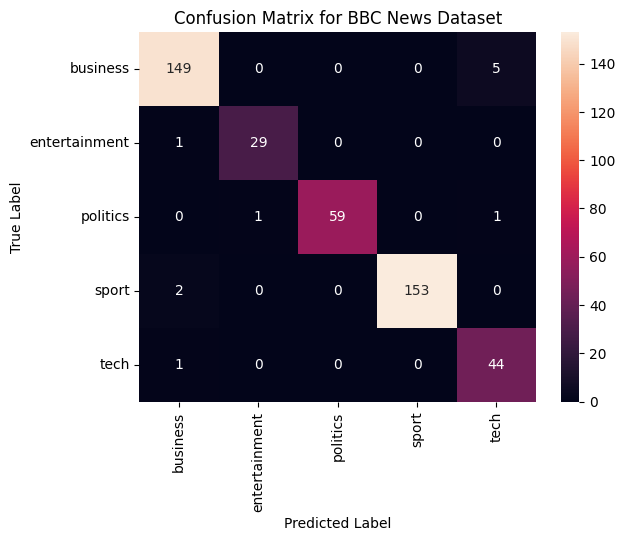

In [28]:
if __name__ == "__main__":

  wandb.login()
  run = wandb.init(project="DIT-Bert-bbc-news-project")
  our_bert_dataset = CustomBertDataset(DS_PATH)
  print(f"Size of bert dataset : {len(our_bert_dataset)}")
  train_dataset = Subset(our_bert_dataset, range(int(len(our_bert_dataset)*0.8)))
  test_dataset = Subset(our_bert_dataset, range(int(len(our_bert_dataset)*0.8), len(our_bert_dataset)))

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  our_bert_model = CustomBertModel(our_bert_dataset.num_class)
  our_bert_model = our_bert_model.to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(filter(lambda p: p.requires_grad, our_bert_model.parameters()), lr=0.01)

  train_step(our_bert_model, train_dataloader, loss_fn, optimizer)

  eval_step(test_dataloader, loss_fn, our_bert_dataset.num_class)
